In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import time
import sys
sys.path.append('../../wrapper')
import xgboost
from xgboost import XGBClassifier
from collections import Counter

import os
import glob
import seaborn
import mglearn
import sklearn
import sklearn.datasets
from numpy import random

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve, StratifiedKFold, ShuffleSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE, RFECV

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score, classification_report

from sklearn.svm import SVC
from sklearn import pipeline
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from matplotlib.ticker import FormatStrFormatter

from string import ascii_letters
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
shap.initjs()
import warnings
warnings.filterwarnings('ignore')
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
shap_values_svm_1_train = pd.read_csv("df_shap_values_svm_1_train_syn.csv", sep='\t', index_col=0)
shap_values_svm_1_test = pd.read_csv("df_shap_values_svm_1_test_syn.csv", sep='\t', index_col=0)

shap_values_svm_01_train = pd.read_csv("df_shap_values_svm_01_train_syn.csv", sep='\t', index_col=0)
shap_values_svm_01_test = pd.read_csv("df_shap_values_svm_01_test_syn.csv", sep='\t', index_col=0)

shap_values_svm_005_train = pd.read_csv("df_shap_values_svm_3_train_syn.csv", sep='\t', index_col=0)
shap_values_svm_005_test = pd.read_csv("df_shap_values_svm_3_test_syn.csv", sep='\t', index_col=0)

shap_values_svm_011_train = pd.read_csv("df_shap_values_svm_011_train_syn.csv", sep='\t', index_col=0)
shap_values_svm_011_test = pd.read_csv("df_shap_values_svm_011_test_syn.csv", sep='\t', index_col=0)

shap_values_svm_012_train = pd.read_csv("df_shap_values_svm_4_train_syn.csv", sep='\t', index_col=0)
shap_values_svm_012_test = pd.read_csv("df_shap_values_svm_4_test_syn.csv", sep='\t', index_col=0)

shap_values_rf_1_train = pd.read_csv("df_shap_values_rf_1_train_syn.csv", sep='\t', index_col=0)
shap_values_rf_1_test = pd.read_csv("df_shap_values_rf_1_test_syn.csv", sep='\t', index_col=0)

shap_values_rf_2_train = pd.read_csv("df_shap_values_rf_2_train_syn.csv", sep='\t', index_col=0)
shap_values_rf_2_test = pd.read_csv("df_shap_values_rf_2_test_syn.csv", sep='\t', index_col=0)

In [3]:
shap_values_svm_013_train = pd.read_csv("df_shap_values_svm_5_train_syn.csv", sep='\t', index_col=0)
shap_values_svm_013_test = pd.read_csv("df_shap_values_svm_5_test_syn.csv", sep='\t', index_col=0)

In [4]:
X_train_selected = pd.read_csv("df_X_train_selected_syn.csv", sep='\t', index_col=0)
X_test_selected = pd.read_csv("df_X_test_selected_syn.csv", sep='\t', index_col=0)

y_train_sampled = pd.read_csv("df_y_train_sampled_syn.csv", sep='\t', index_col=0)
y_test = pd.read_csv("df_y_test_syn.csv", sep='\t', index_col=0)

In [5]:
df_shap_xgb_train = pd.DataFrame(shap_values_xgb_train[:, 1, :][:, :-1], columns=list(shap_values_rf_1_train))
df_shap_xgb_test = pd.DataFrame(shap_values_xgb_test[:, 1, :][:, :-1], columns=list(shap_values_rf_1_test))

NameError: name 'shap_values_xgb_train' is not defined

In [63]:
### predict ori with 2 features
# X_train_selected_retrain = X_train_selected.iloc[:, [2, 4]]
# X_test_selected_retrain = X_test_selected.iloc[:, [2, 4]]
# selection_model = RandomForestClassifier(n_estimators=1, random_state=0)
# selection_model.fit(X_train_selected_retrain, np.array(y_train_sampled).ravel())
# rf_1_predict_2_ori_feature = selection_model.predict(X_test_selected_retrain)
# rf_1_proba_2_ori_feature = selection_model.predict_proba(X_test_selected_retrain)[:,1]

def get_df(clf1, clf2, clf3, shap_values_train, shap_values_test):
    tmp_X = X_test_selected.reset_index(drop=True)
    tmp = tmp_X.join(shap_values_test)#(df_shap_xgb_test)
    tmp2 = tmp.join(y_test)
    ### predict ori with all the features
    selection_model = clf1
    selection_model.fit(X_train_selected, np.array(y_train_sampled).ravel())
    predict_ori_feature = selection_model.predict(X_test_selected)
    proba_ori_feature = selection_model.predict_proba(X_test_selected)[:,1]

    X_train_selected_shap = shap_values_train.iloc[:, [4, 2]]
    X_test_selected_shap = shap_values_test.iloc[:, [4, 2]]
    selection_model_shap = clf2
    selection_model_shap.fit(X_train_selected_shap, np.array(y_train_sampled).ravel())
    predict_2_shap_feature = selection_model_shap.predict(X_test_selected_shap)
    proba_2_shap_feature = selection_model_shap.predict_proba(X_test_selected_shap)[:,1]

    selection_model_shap_ori = clf3
    selection_model_shap_ori.fit(X_train_selected_shap, selection_model.predict(X_train_selected))
    predict_2_shap_feature_ori = selection_model_shap_ori.predict(X_test_selected_shap)

    proba_2_shap_feature_ori = selection_model_shap_ori.predict_proba(X_test_selected_shap)[:,1]
    return tmp2, predict_ori_feature, proba_ori_feature, predict_2_shap_feature, proba_2_shap_feature, predict_2_shap_feature_ori, proba_2_shap_feature_ori

In [91]:
clf1 = RandomForestClassifier(n_estimators=1, random_state=0)
clf2 = RandomForestClassifier(n_estimators=1, random_state=0)
clf3 = RandomForestClassifier(n_estimators=1, random_state=0)
tmp2, predict_ori_feature, proba_ori_feature, predict_2_shap_feature, proba_2_shap_feature, predict_2_shap_feature_ori, proba_2_shap_feature_ori = get_df(clf1, clf2, clf3, 
      shap_values_rf_1_train, shap_values_rf_1_test)

# clf1 = SVC(gamma=0.05, probability=True)
# clf2 = SVC(gamma=0.05, probability=True)
# clf3 = SVC(gamma=0.05, probability=True)

# tmp2, predict_ori_feature, proba_ori_feature, predict_2_shap_feature, proba_2_shap_feature, predict_2_shap_feature_ori, proba_2_shap_feature_ori = get_df(clf1, clf2, clf3, 
#                 shap_values_svm_005_train, shap_values_svm_005_test)

In [92]:
# xgb_train = xgboost.DMatrix(X_train_selected, label=y_train_sampled)
# xgb_test = xgboost.DMatrix(X_test_selected, label=y_test)
# params = {'max_depth':20, 'n_estimators':1,
#          'objective': 'multi:softprob', 'num_class': 2
# }

# selection_model = xgboost.train(params, xgb_train, 100)
# proba_ori_feature = selection_model.predict(xgb_test)[:,1]

In [93]:
df_predict_ori_feature = pd.DataFrame(predict_ori_feature, columns=['predict_ori'])
df_proba_ori_feature = pd.DataFrame(proba_ori_feature, columns=['proba_ori'])
df_predict_2_shap_feature = pd.DataFrame(predict_2_shap_feature, columns=['predict_shap'])
df_proba_2_shap_feature = pd.DataFrame(proba_2_shap_feature, columns=['proba_shap'])
df_predict_2_shap_feature_ori = pd.DataFrame(predict_2_shap_feature_ori, columns=['predict_shap_ori'])
df_proba_2_shap_feature_ori = pd.DataFrame(proba_2_shap_feature_ori, columns=['proba_shap_ori'])

tmp3 = tmp2.join(df_predict_ori_feature)
tmp4 = tmp3.join(df_predict_2_shap_feature)
tmp5 = tmp4.join(df_predict_2_shap_feature_ori)
tmp6 = tmp5.join(df_proba_ori_feature)
tmp7 = tmp6.join(df_proba_2_shap_feature)
tmp8 = tmp7.join(df_proba_2_shap_feature_ori)

In [94]:
from scipy import spatial
from scipy.stats import entropy
from numpy.linalg import norm

hist, bin_edges = np.histogram(tmp8['proba_ori'], bins=np.linspace(0, 1, 21)) 

dist_label = np.zeros(len(hist))
dist_label[0] = tmp8['label'].value_counts()[0]
dist_label[-1] = tmp8['label'].value_counts()[1]

result = 1 - spatial.distance.cosine(hist, dist_label)

def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

1-JSD(hist, dist_label)

0.9997386128001557

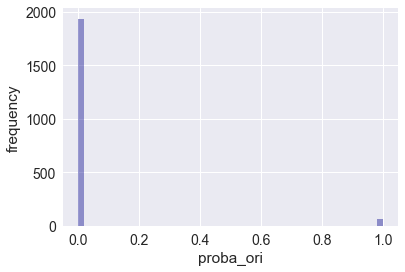

In [95]:
# fg = seaborn.FacetGrid(data=tmp5, hue='proba_ori', aspect=1, size=7)#palette=col_list_palette
# fg.map(plt.scatter, 'a*b', 'c').add_legend()
# tmp5['proba_ori'].value_counts()
sns.set(font_scale=1.4)
# sns.set(style='dark', font_scale=1.6)
plot = sns.distplot(tmp8['proba_ori'], bins=56, color="darkblue", kde=False).set(xlim=(-0.05, 1.05),
                                                                                 xticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                                                                 ylabel='frequency');

In [96]:
roc_auc_score(y_test, tmp5['predict_ori'])
roc_auc_score(y_test, tmp5['predict_shap'])

0.9961577868852459

In [97]:
tmp8['condition_ori'] = 'condition'
tmp8['condition_ori'].loc[((tmp8['label']==True) & (tmp8['predict_ori']==True))] = 'TP'
tmp8['condition_ori'].loc[((tmp8['label']==False) & (tmp8['predict_ori']==True))] = 'FP'
tmp8['condition_ori'].loc[((tmp8['label']==True) & (tmp8['predict_ori']==False))] = 'FN'
tmp8['condition_ori'].loc[((tmp8['label']==False) & (tmp8['predict_ori']==False))] = 'TN'
tmp8['condition_ori'].value_counts()

TN    1937
TP      48
FP      15
Name: condition_ori, dtype: int64

In [98]:
tmp8['condition_shap'] = 'condition'
tmp8['condition_shap'].loc[((tmp8['label']==True) & (tmp8['predict_shap']==True))] = 'TP'
tmp8['condition_shap'].loc[((tmp8['label']==False) & (tmp8['predict_shap']==True))] = 'FP'
tmp8['condition_shap'].loc[((tmp8['label']==True) & (tmp8['predict_shap']==False))] = 'FN'
tmp8['condition_shap'].loc[((tmp8['label']==False) & (tmp8['predict_shap']==False))] = 'TN'
tmp8['condition_shap'].value_counts()

TN    1937
TP      48
FP      15
Name: condition_shap, dtype: int64

In [99]:
tmp8['shap_ori'] = 'condition'
tmp8['shap_ori'].loc[((tmp8['predict_ori']==True) & (tmp8['predict_shap_ori']==True))] = 'TP'
tmp8['shap_ori'].loc[((tmp8['predict_ori']==False) & (tmp8['predict_shap_ori']==True))] = 'FP'
tmp8['shap_ori'].loc[((tmp8['predict_ori']==True) & (tmp8['predict_shap_ori']==False))] = 'FN'
tmp8['shap_ori'].loc[((tmp8['predict_ori']==False) & (tmp8['predict_shap_ori']==False))] = 'TN'
tmp8['shap_ori'].value_counts()

TN    1937
TP      63
Name: shap_ori, dtype: int64

In [100]:
tmp8['FPtoTN'] = False
tmp8['FPtoTN'].loc[((tmp8['condition_ori']=='FP') & (tmp8['condition_shap']=='TN'))] = True
tmp8['FPtoTN'].value_counts()

False    2000
Name: FPtoTN, dtype: int64

In [105]:
tmp8[(tmp8['predict_ori']==False) & (tmp8['a*b_SHAP']>0) & (tmp8['c_SHAP']>0)].iloc[:, 0:16]

,a,b,c,d,a*b,a/b,19,306,343,378,426,a_SHAP,b_SHAP,c_SHAP,d_SHAP,a*b_SHAP
79,8,7,10,9,56,1.142857,2,5,5,4,7,0.016071,0.012160,0.033787,-0.542857,0.018991
218,7,8,8,10,56,0.875000,2,5,10,10,5,0.016185,0.013180,0.034325,-0.542857,0.022817
249,10,9,10,9,90,1.111111,2,10,5,3,8,0.017999,0.025765,0.042404,-0.542857,0.043651
365,10,10,10,9,100,1.000000,9,4,5,1,2,0.017999,0.025765,0.042404,-0.542857,0.043651
439,8,10,10,10,80,0.800000,10,7,1,9,6,0.017999,0.025765,0.042404,-0.542857,0.043651
513,10,7,9,10,70,1.428571,4,9,8,8,6,0.016695,0.017602,0.036678,-0.542857,0.033617
811,7,9,9,9,63,0.777778,7,4,8,10,7,0.016695,0.017602,0.036678,-0.542857,0.033617
882,6,10,9,8,60,0.600000,3,4,4,10,10,0.018282,0.028260,0.044218,-0.542857,0.043651
1003,7,8,8,8,56,0.875000,8,2,10,10,3,0.016185,0.013180,0.034325,-0.542857,0.022817
1013,8,8,10,10,64,1.000000,5,1,9,2,9,0.018396,0.029280,0.044756,-0.542857,0.033617


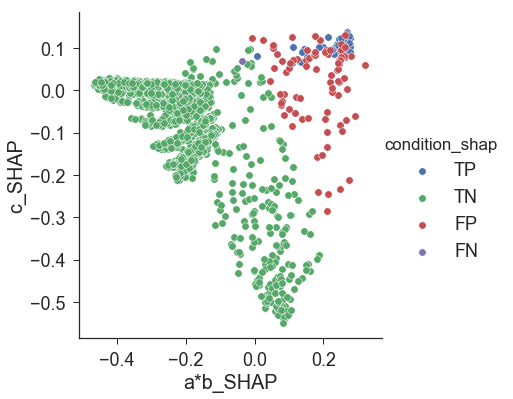

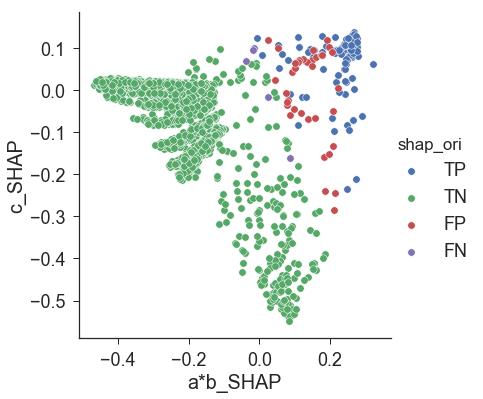

In [90]:

# col_list = ["cool blue", "red"]
col_list = ["red", "cool blue"]
col_list_palette = sns.xkcd_palette(col_list)
SEABORN_PALETTES = dict(
    deep=["#4C72B0", "#55A868", "#C44E52",
          "#8172B2", "#CCB974", "#64B5CD"],
    muted=["#4878CF", "#6ACC65", "#D65F5F",
           "#B47CC7", "#C4AD66", "#77BEDB"],
    pastel=["#92C6FF", "#97F0AA", "#FF9F9A",
            "#D0BBFF", "#FFFEA3", "#B0E0E6"],
    bright=["#003FFF", "#03ED3A", "#E8000B",
            "#8A2BE2", "#FFC400", "#00D7FF"],
    dark=["#001C7F", "#017517", "#8C0900",
          "#7600A1", "#B8860B", "#006374"],
    colorblind=["#0072B2", "#009E73", "#D55E00",
                "#CC79A7", "#F0E442", "#56B4E9"]
    )
seaborn.set(style='ticks', font_scale=1.8, palette="deep")
deep=["#77aaff", "#017517"]
deep=["#017517", "#77aaff"]

kws = dict(s=55, linewidth=.5, edgecolor="w")

# fg = seaborn.FacetGrid(data=tmp8, hue='proba_shap_ori',  aspect=1, size=6)#, hue_order=[1.0, 0.0]) #
# fg.map(plt.scatter, 'a*b_SHAP', 'c_SHAP', **kws).add_legend()
# fg.savefig("/Users/lillian/Desktop/output2.png")

fg = seaborn.FacetGrid(data=tmp8, hue='condition_shap', aspect=1, size=6, hue_order=['TP', 'TN', 'FP', 'FN'])
fg.map(plt.scatter, 'a*b_SHAP', 'c_SHAP', **kws).add_legend()
fg.savefig("/Users/lillian/Desktop/output1.png")

fg = seaborn.FacetGrid(data=tmp8, hue='shap_ori', aspect=1, size=6, hue_order=['TP', 'TN', 'FP', 'FN'])
fg.map(plt.scatter, 'a*b_SHAP', 'c_SHAP', **kws).add_legend()
fg.savefig("/Users/lillian/Desktop/output2.png")

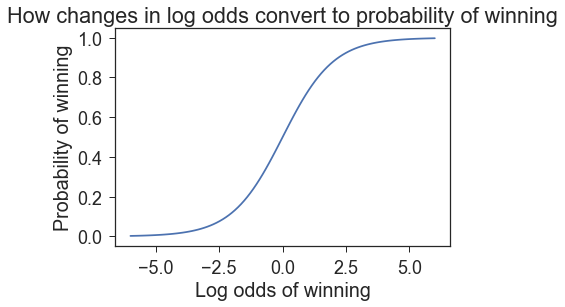

In [38]:
xs = np.linspace(-6,6,100)
plt.xlabel("Log odds of winning")
plt.ylabel("Probability of winning")
plt.title("How changes in log odds convert to probability of winning")
plt.plot(xs, 1/(1+np.exp(-xs)))
plt.show()

In [39]:
# tmp5[(tmp5['a*b'] > 55) & (tmp5['predict_ori']==True)].sort_values(by='c')

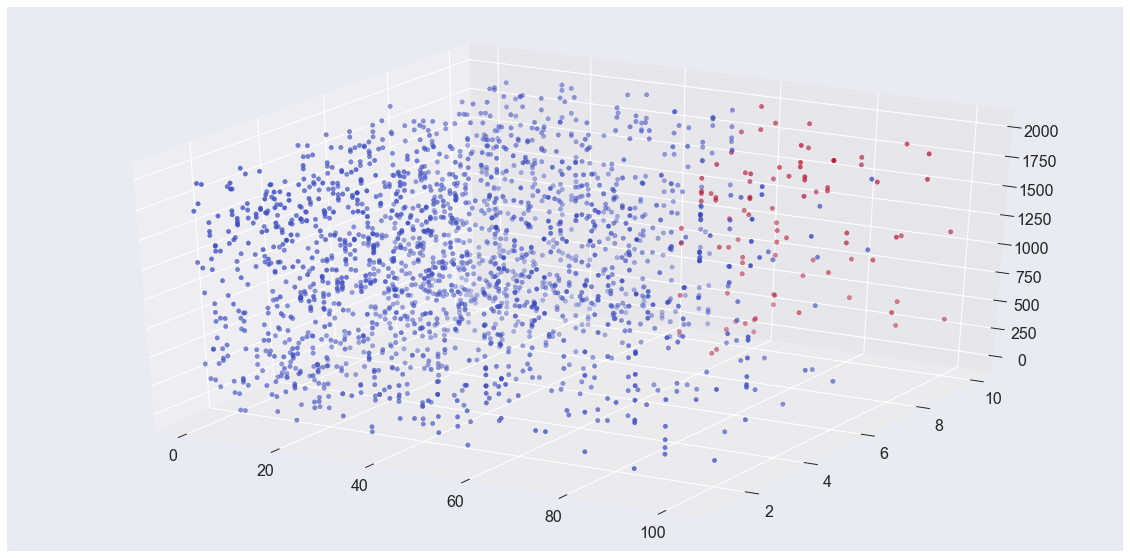

In [921]:
from mpl_toolkits import mplot3d
rgb = np.random.random((10, 3))

plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(tmp5['a*b'], tmp5['c'], tmp5.index, c=tmp5['predict_ori'], cmap='coolwarm');

In [107]:
i = 79

selection_model = RandomForestClassifier(n_estimators=1, random_state=0)
selection_model.fit(X_train_selected, np.array(y_train_sampled).ravel())

explainer = shap.KernelExplainer(selection_model.predict_proba, X_test_selected.iloc[i, :])
tmp_exp = explainer.shap_values(X_test_selected.iloc[i, :])

In [116]:
# shap.force_plot(tmp[1], X_test_selected.iloc[0:20, :])
shap.force_plot(tmp_exp[1], X_test_selected.iloc[i, :])

In [546]:
tmp5['proba_ori'][0:20].mean()

0.05

In [5]:
def feature_elimination(clf, X_train_selected, X_test_selected):
    features = np.linspace(X_train_selected.shape[1], 1, X_train_selected.shape[1])
    n_retrain = []
    roc_scores_retrain = []

    for n_features in features:
        select = RFE(RandomForestClassifier(n_estimators=100, random_state=0), n_features)
#         select = RFECV(RandomForestClassifier(n_estimators=100, random_state=0), step=1, cv=5, scoring='roc_auc')
        select.fit(X_train_selected, np.array(y_train_sampled).ravel())
        idxs_selected = select.get_support(indices=True)

        X_train_selected_retrain = X_train_selected.iloc[:, idxs_selected]
        X_test_selected_retrain = X_test_selected.iloc[:, idxs_selected]

        selection_model = clf
        selection_model.fit(X_train_selected_retrain, np.array(y_train_sampled).ravel())

        roc = roc_auc_score(y_test, selection_model.predict(X_test_selected_retrain))
        roc_scores_retrain.append(roc)
        n_retrain.append(X_train_selected_retrain.shape[1])
        print("n=%d, AUC score: %.3f" % (X_train_selected_retrain.shape[1], roc))
        print("The selected feature", X_train_selected_retrain.columns)
#         plt.plot(range(1, len(select.grid_scores_) + 1),  select.grid_scores_)

    return n_retrain, roc_scores_retrain

In [6]:
def feature_elimination_shap(clf, shap_values_train, shap_values_test):
    features = np.linspace(shap_values_train.shape[1], 1, shap_values_train.shape[1]).astype(int)
    n_retrain = []
    roc_scores_retrain = []
    rank = shap_values_train.abs().mean().rank()
#     rank = X_train_selected.quantile(0.75, axis=0).rank()
    X_train_selected_sorted =shap_values_train.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    X_test_selected_sorted = shap_values_test.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    

    for n_features in features:
        X_train_selected_retrain = X_train_selected_sorted.iloc[:, 0:n_features]
        X_test_selected_retrain = X_test_selected_sorted.iloc[:, 0:n_features]

        selection_model = clf
        selection_model.fit(X_train_selected_retrain, np.array(y_train_sampled).ravel())

        roc = roc_auc_score(y_test, selection_model.predict(X_test_selected_retrain))
        roc_scores_retrain.append(roc)
        n_retrain.append(X_train_selected_retrain.shape[1])
        print("n=%d, AUC score: %.3f" % (X_train_selected_retrain.shape[1], roc))
        print("The selected feature", X_train_selected_retrain.columns)
    return n_retrain, roc_scores_retrain

In [7]:
def confusion_matrix_plot(X_valid, y_valid, clf):
    plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'axes.titlesize': 16})
    plt.rcParams.update({'axes.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    plt.rcParams.update({'xtick.labelsize': 16})
    f, ax = plt.subplots(figsize=(6, 6))
    target_names = ['Not Mo1', 'Mo1']
    scores_image = mglearn.tools.heatmap(
        confusion_matrix(y_valid, clf.predict(X_valid)), xlabel='Predicted label',
        ylabel='True label', xticklabels=target_names,
        yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
    plt.title("Confusion matrix")
    plt.gca().invert_yaxis()

In [8]:
def feature_elimination_shap_ori(clf, clf_cp, X_train_selected, X_test_selected, shap_values_train, shap_values_test):
    features = np.linspace(shap_values_train.shape[1], 1, shap_values_train.shape[1]).astype(int)
    n_retrain = []
    roc_scores_retrain = []
    rank = shap_values_train.abs().mean().rank()
#     rank = X_train_selected.quantile(0.75, axis=0).rank()
    X_train_selected_sorted = shap_values_train.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    X_test_selected_sorted = shap_values_test.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    ori_model = clf_cp
    ori_model.fit(X_train_selected, np.array(y_train_sampled).ravel())
    for n_features in features:
        X_train_selected_retrain = X_train_selected_sorted.iloc[:, 0:n_features]
        X_test_selected_retrain = X_test_selected_sorted.iloc[:, 0:n_features]

        selection_model = clf
        selection_model.fit(X_train_selected_retrain, ori_model.predict(X_train_selected))
        roc = roc_auc_score(ori_model.predict(X_test_selected), selection_model.predict(X_test_selected_retrain))
        roc_scores_retrain.append(roc)
        n_retrain.append(X_train_selected_retrain.shape[1])
        print("n=%d, AUC score: %.3f" % (X_train_selected_retrain.shape[1], roc))
        print("The selected feature", X_train_selected_retrain.columns)
    return n_retrain, roc_scores_retrain

In [9]:
def plot_feature_selection(n_retrain, roc_scores_retrain, n_shap, roc_scores_shap, n_shap_ori, roc_scores_shap_ori):
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({'axes.titlesize': 14})
    plt.rcParams.update({'axes.labelsize': 14})
    plt.rcParams.update({'ytick.labelsize': 14})
    plt.rcParams.update({'xtick.labelsize': 14})
    fig = plt.figure(figsize=(20, 5))
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.plot(n_retrain, np.asarray(roc_scores_retrain), c='b', label='Original features vs Label')
    ax2.plot(n_shap, np.asarray(roc_scores_shap), c='r', label='SHAP features vs Label')
    ax2.plot(n_shap_ori, np.asarray(roc_scores_shap_ori), c='g', label='SHAP features vs Original features')
    ax2.set_xlim(12, 0)
    ax2.set_ylim(0.8, 1.05)
    ax2.set_xlabel("Number of features")
    ax2.set_ylabel("AUC-ROC")
    ax2.legend(loc=4, prop={'size': 12})

In [10]:
svm_1 = SVC(gamma=1, probability=True) 
svm_1_cp = SVC(gamma=1, probability=True) 
n_retrain_svm_1, roc_scores_retrain_svm_1 = feature_elimination(svm_1, X_train_selected, X_test_selected)
n_shap_svm_1, roc_scores_shap_svm_1 = feature_elimination_shap(svm_1, shap_values_svm_1_train, shap_values_svm_1_test)
n_shap_ori_svm_1, roc_scores_shap_ori_svm_1 = feature_elimination_shap_ori(svm_1, svm_1_cp, X_train_selected, X_test_selected,
                                                                           shap_values_svm_1_train, shap_values_svm_1_test)

n=11, AUC score: 0.500
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '343', '378', '426'], dtype='object')
n=10, AUC score: 0.500
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378', '426'], dtype='object')
n=9, AUC score: 0.500
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378'], dtype='object')
n=8, AUC score: 0.521
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '378'], dtype='object')
n=7, AUC score: 0.749
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '378'], dtype='object')
n=6, AUC score: 0.978
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b'], dtype='object')
n=5, AUC score: 0.978
The selected feature Index(['a', 'b', 'c', 'd', 'a*b'], dtype='object')
n=4, AUC score: 0.979
The selected feature Index(['b', 'c', 'd', 'a*b'], dtype='object')
n=3, AUC score: 0.990
The selected feature Index(['c', 'd', 'a*b'], dtype='object')
n=2, AUC score: 0.990
Th

TypeError: feature_elimination_shap_ori() missing 2 required positional arguments: 'shap_values_train' and 'shap_values_test'

In [11]:
svm_01 = SVC(gamma=0.1, probability=True) 
svm_01_cp = SVC(gamma=0.1, probability=True) 
n_retrain_svm_01, roc_scores_retrain_svm_01 = feature_elimination(svm_01, X_train_selected, X_test_selected)
n_shap_svm_01, roc_scores_shap_svm_01 = feature_elimination_shap(svm_01, shap_values_svm_01_train, shap_values_svm_01_test)
n_shap_ori_svm_01, roc_scores_shap_ori_svm_01 = feature_elimination_shap_ori(svm_01, svm_01_cp, X_train_selected, X_test_selected,
                                                                             shap_values_svm_01_train, shap_values_svm_01_test)

n=11, AUC score: 0.810
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '343', '378', '426'], dtype='object')
n=10, AUC score: 0.870
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378', '426'], dtype='object')
n=9, AUC score: 0.930
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378'], dtype='object')
n=8, AUC score: 0.981
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '378'], dtype='object')
n=7, AUC score: 0.989
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '378'], dtype='object')
n=6, AUC score: 0.990
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b'], dtype='object')
n=5, AUC score: 0.990
The selected feature Index(['a', 'b', 'c', 'd', 'a*b'], dtype='object')
n=4, AUC score: 0.989
The selected feature Index(['b', 'c', 'd', 'a*b'], dtype='object')
n=3, AUC score: 0.989
The selected feature Index(['c', 'd', 'a*b'], dtype='object')
n=2, AUC score: 0.984
Th

In [12]:
svm_011 = SVC(gamma=0.11, probability=True) 
svm_011_cp = SVC(gamma=0.11, probability=True) 
n_retrain_svm_011, roc_scores_retrain_svm_011 = feature_elimination(svm_011, X_train_selected, X_test_selected)
n_shap_svm_011, roc_scores_shap_svm_011 = feature_elimination_shap(svm_011, shap_values_svm_011_train, shap_values_svm_011_test)
n_shap_ori_svm_011, roc_scores_shap_ori_svm_011 = feature_elimination_shap_ori(svm_011, svm_011_cp, X_train_selected, X_test_selected, 
                                                                               shap_values_svm_011_train, shap_values_svm_011_test)

n=11, AUC score: 0.758
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '343', '378', '426'], dtype='object')
n=10, AUC score: 0.870
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378', '426'], dtype='object')
n=9, AUC score: 0.931
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378'], dtype='object')
n=8, AUC score: 0.981
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '378'], dtype='object')
n=7, AUC score: 0.990
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '378'], dtype='object')
n=6, AUC score: 0.990
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b'], dtype='object')
n=5, AUC score: 0.990
The selected feature Index(['a', 'b', 'c', 'd', 'a*b'], dtype='object')
n=4, AUC score: 0.990
The selected feature Index(['b', 'c', 'd', 'a*b'], dtype='object')
n=3, AUC score: 0.989
The selected feature Index(['c', 'd', 'a*b'], dtype='object')
n=2, AUC score: 0.984
Th

In [13]:
svm_012 = SVC(gamma=0.12, probability=True) 
svm_012_cp = SVC(gamma=0.12, probability=True) 
n_retrain_svm_012, roc_scores_retrain_svm_012 = feature_elimination(svm_012, X_train_selected, X_test_selected)
n_shap_svm_012, roc_scores_shap_svm_012 = feature_elimination_shap(svm_012, shap_values_svm_012_train, 
                                                               shap_values_svm_012_test)
n_shap_ori_svm_012, roc_scores_shap_ori_svm_012 = feature_elimination_shap_ori(svm_012, svm_012_cp, X_train_selected, X_test_selected,
                                                                               shap_values_svm_012_train, shap_values_svm_012_test)

n=11, AUC score: 0.707
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '343', '378', '426'], dtype='object')
n=10, AUC score: 0.850
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378', '426'], dtype='object')
n=9, AUC score: 0.901
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378'], dtype='object')
n=8, AUC score: 0.971
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '378'], dtype='object')
n=7, AUC score: 0.991
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '378'], dtype='object')
n=6, AUC score: 0.990
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b'], dtype='object')
n=5, AUC score: 0.990
The selected feature Index(['a', 'b', 'c', 'd', 'a*b'], dtype='object')
n=4, AUC score: 0.990
The selected feature Index(['b', 'c', 'd', 'a*b'], dtype='object')
n=3, AUC score: 0.990
The selected feature Index(['c', 'd', 'a*b'], dtype='object')
n=2, AUC score: 0.984
Th

In [ ]:
svm_013 = SVC(gamma=0.13, probability=True) 
svm_013_cp = SVC(gamma=0.13, probability=True) 
n_retrain_svm_013, roc_scores_retrain_svm_013 = feature_elimination(svm_013, X_train_selected, X_test_selected)
n_shap_svm_013, roc_scores_shap_svm_013 = feature_elimination_shap(svm_013, shap_values_svm_013_train, 
                                                               shap_values_svm_013_test)
n_shap_ori_svm_013, roc_scores_shap_ori_svm_013 = feature_elimination_shap_ori(svm_013, svm_013_cp, shap_values_svm_013_train, 
                                                               shap_values_svm_013_test)

In [14]:
svm_005 = SVC(gamma=0.05, probability=True) 
svm_005_cp = SVC(gamma=0.05, probability=True) 
n_retrain_svm_005, roc_scores_retrain_svm_005 = feature_elimination(svm_005, X_train_selected, X_test_selected)
n_shap_svm_005, roc_scores_shap_svm_005 = feature_elimination_shap(svm_005, shap_values_svm_005_train, 
                                                                   shap_values_svm_005_test)
n_shap_ori_svm_005, roc_scores_shap_ori_svm_005 = feature_elimination_shap_ori(svm_005, svm_005_cp, X_train_selected, X_test_selected,
                                                                               shap_values_svm_005_train, shap_values_svm_005_test)

n=11, AUC score: 0.945
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '343', '378', '426'], dtype='object')
n=10, AUC score: 0.975
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378', '426'], dtype='object')
n=9, AUC score: 0.975
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378'], dtype='object')
n=8, AUC score: 0.984
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '378'], dtype='object')
n=7, AUC score: 0.985
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '378'], dtype='object')
n=6, AUC score: 0.986
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b'], dtype='object')
n=5, AUC score: 0.986
The selected feature Index(['a', 'b', 'c', 'd', 'a*b'], dtype='object')
n=4, AUC score: 0.986
The selected feature Index(['b', 'c', 'd', 'a*b'], dtype='object')
n=3, AUC score: 0.986
The selected feature Index(['c', 'd', 'a*b'], dtype='object')
n=2, AUC score: 0.980
Th

In [15]:
rf_1 = RandomForestClassifier(n_estimators=1, random_state=0)
rf_1_cp = RandomForestClassifier(n_estimators=1, random_state=0)
n_retrain_rf_1, roc_scores_retrain_rf_1 = feature_elimination(rf_1, X_train_selected, X_test_selected)
n_shap_rf_1, roc_scores_shap_rf_1 = feature_elimination_shap(rf_1, shap_values_rf_1_train, shap_values_rf_1_test)
n_shap_ori_rf_1, roc_scores_shap_ori_rf_1 = feature_elimination_shap_ori(rf_1, rf_1_cp, X_train_selected, X_test_selected, 
                                                                         shap_values_rf_1_train, shap_values_rf_1_test)

n=11, AUC score: 0.996
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '343', '378', '426'], dtype='object')
n=10, AUC score: 0.949
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378', '426'], dtype='object')
n=9, AUC score: 0.996
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378'], dtype='object')
n=8, AUC score: 0.974
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '378'], dtype='object')
n=7, AUC score: 0.981
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '378'], dtype='object')
n=6, AUC score: 0.995
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b'], dtype='object')
n=5, AUC score: 0.994
The selected feature Index(['a', 'b', 'c', 'd', 'a*b'], dtype='object')
n=4, AUC score: 0.992
The selected feature Index(['b', 'c', 'd', 'a*b'], dtype='object')
n=3, AUC score: 0.996
The selected feature Index(['c', 'd', 'a*b'], dtype='object')
n=2, AUC score: 0.990
Th

In [16]:
rf_2 = RandomForestClassifier(n_estimators=2, random_state=0)
rf_2_cp = RandomForestClassifier(n_estimators=2, random_state=0)
n_retrain_rf_2, roc_scores_retrain_rf_2 = feature_elimination(rf_2, X_train_selected, X_test_selected)
n_shap_rf_2, roc_scores_shap_rf_2 = feature_elimination_shap(rf_2, shap_values_rf_2_train, shap_values_rf_2_test)
n_shap_ori_rf_2, roc_scores_shap_ori_rf_2 = feature_elimination_shap_ori(rf_2, rf_2_cp, X_train_selected, X_test_selected, shap_values_rf_2_train, shap_values_rf_2_test)

n=11, AUC score: 0.965
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '343', '378', '426'], dtype='object')
n=10, AUC score: 0.942
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378', '426'], dtype='object')
n=9, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378'], dtype='object')
n=8, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '378'], dtype='object')
n=7, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '378'], dtype='object')
n=6, AUC score: 0.999
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b'], dtype='object')
n=5, AUC score: 0.994
The selected feature Index(['a', 'b', 'c', 'd', 'a*b'], dtype='object')
n=4, AUC score: 0.999
The selected feature Index(['b', 'c', 'd', 'a*b'], dtype='object')
n=3, AUC score: 1.000
The selected feature Index(['c', 'd', 'a*b'], dtype='object')
n=2, AUC score: 0.990
Th

In [1016]:
plot_feature_selection(n_retrain_svm_1, roc_scores_retrain_svm_1, n_shap_svm_1, roc_scores_shap_svm_1,
                      n_shap_ori_svm_1, roc_scores_shap_ori_svm_1)

NameError: name 'n_shap_ori_svm_1' is not defined

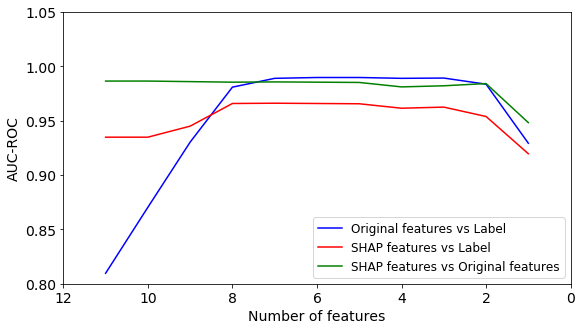

In [17]:
plot_feature_selection(n_retrain_svm_01, roc_scores_retrain_svm_01, n_shap_svm_01, roc_scores_shap_svm_01,
                      n_shap_ori_svm_01, roc_scores_shap_ori_svm_01)

In [18]:
plot_feature_selection(n_retrain_svm_013, roc_scores_retrain_svm_013, n_shap_svm_013, roc_scores_shap_svm_013,
                      n_shap_ori_svm_013, roc_scores_shap_ori_svm_013)

NameError: name 'n_retrain_svm_013' is not defined

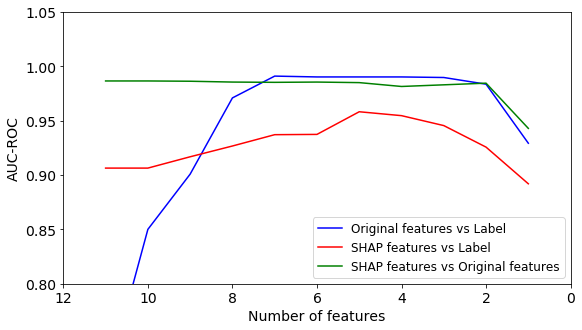

In [19]:
plot_feature_selection(n_retrain_svm_012, roc_scores_retrain_svm_012, n_shap_svm_012, roc_scores_shap_svm_012,
                      n_shap_ori_svm_012, roc_scores_shap_ori_svm_012)

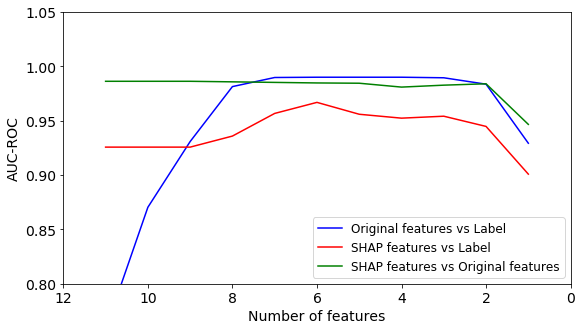

In [20]:
plot_feature_selection(n_retrain_svm_011, roc_scores_retrain_svm_011, n_shap_svm_011, roc_scores_shap_svm_011,
                       n_shap_ori_svm_011, roc_scores_shap_ori_svm_011)

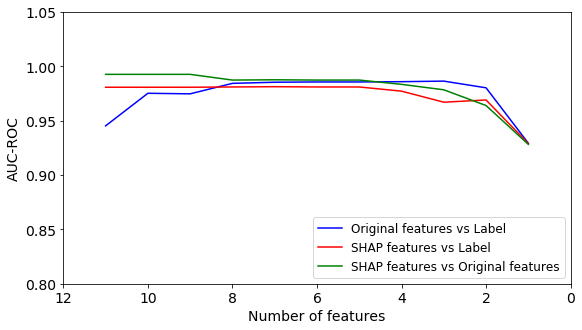

In [21]:
plot_feature_selection(n_retrain_svm_005, roc_scores_retrain_svm_005, n_shap_svm_005, roc_scores_shap_svm_005,
                      n_shap_ori_svm_005, roc_scores_shap_ori_svm_005)

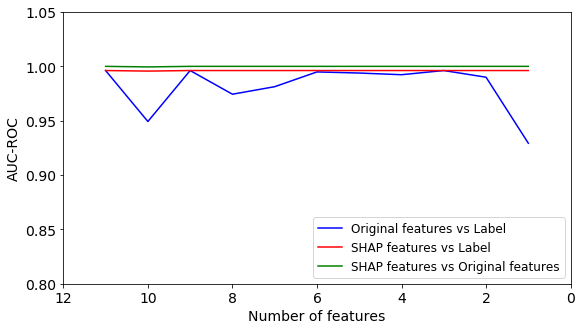

In [22]:
plot_feature_selection(n_retrain_rf_1, roc_scores_retrain_rf_1, n_shap_rf_1, roc_scores_shap_rf_1, 
                       n_shap_ori_rf_1, roc_scores_shap_ori_rf_1)

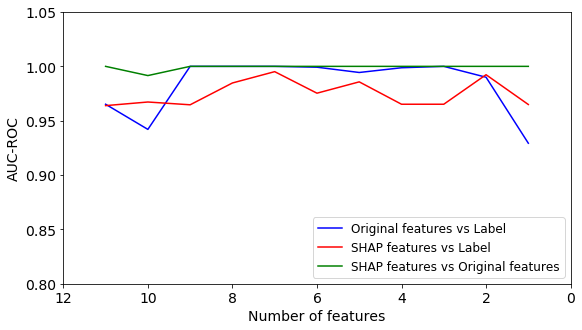

In [23]:
plot_feature_selection(n_retrain_rf_2, roc_scores_retrain_rf_2, n_shap_rf_2, roc_scores_shap_rf_2,
                      n_shap_ori_rf_2, roc_scores_shap_ori_rf_2)

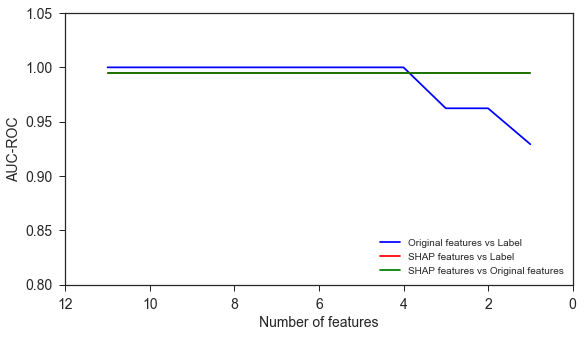

In [400]:
plot_feature_selection(n_retrain_xgb_1, roc_scores_retrain_xgb_1, n_shap_xgb_1, roc_scores_shap_xgb_1,
                      n_shap_ori_xgb_1, roc_scores_shap_ori_xgb_1)

In [81]:
def feature_elimination_xgb(n_estimators, X_train_selected, X_test_selected):
    features = np.linspace(X_train_selected.shape[1], 1, X_train_selected.shape[1])
    n_retrain = []
    roc_scores_retrain = []
    params['n_estimators'] = n_estimators


    for n_features in features:
#         select = RFE(RandomForestClassifier(n_estimators=100, random_state=0), n_features)
        select = RFE(XGBClassifier(n_estimators=500, random_state=0), n_features)
        select.fit(X_train_selected, np.array(y_train_sampled).ravel())
        idxs_selected = select.get_support(indices=True)

        X_train_selected_retrain = X_train_selected.iloc[:, idxs_selected]
        X_test_selected_retrain = X_test_selected.iloc[:, idxs_selected]

        xgb_train_retrain = xgboost.DMatrix(X_train_selected_retrain, label=y_train_sampled)
        xgb_test_retrain = xgboost.DMatrix(X_test_selected_retrain, label=y_test)
    
        selection_model = xgboost.train(params, xgb_train_retrain, 100)
        roc = roc_auc_score(y_test, selection_model.predict(xgb_test_retrain))
    
        roc_scores_retrain.append(roc)
        n_retrain.append(X_train_selected_retrain.shape[1])
        print("n=%d, AUC score: %.3f" % (X_train_selected_retrain.shape[1], roc))
        print("The selected feature", X_train_selected_retrain.columns)

    return n_retrain, roc_scores_retrain

In [106]:
def feature_elimination_xgb_shap_ori(n_estimators, X_train_selected, X_test_selected):
    features = np.linspace(X_train_selected.shape[1], 1, X_train_selected.shape[1]).astype(int)
    n_shap = []
    roc_scores_shap = []
#     rank = X_traintest_selected.quantile(0.75, axis=0).rank()
    rank = X_train_selected.abs().mean().rank()
    X_train_selected_sorted = X_train_selected.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    X_test_selected_sorted = X_test_selected.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    params['n_estimators'] = n_estimators
    ori_model = xgboost.train(params, xgb_train, 100)

    for n_features in features:
        X_train_shap_retrain = X_train_selected_sorted.iloc[:, 0:n_features]
        X_test_shap_retrain = X_test_selected_sorted.iloc[:, 0:n_features]
        
        xgb_train_shap_retrain = xgboost.DMatrix(X_train_shap_retrain, label=y_train_sampled)
        xgb_test_shap_retrain = xgboost.DMatrix(X_test_shap_retrain, label=y_test)
    
        selection_model = xgboost.train(params, xgb_train_shap_retrain, 100)
        roc = roc_auc_score(ori_model.predict(xgb_test), selection_model.predict(xgb_test_shap_retrain))

        roc_scores_shap.append(roc)
        n_shap.append(X_train_shap_retrain.shape[1])
        print("n=%d, AUC score: %.3f" % (X_train_shap_retrain.shape[1], roc))
        print("The selected feature", X_train_shap_retrain.columns)
    return n_shap, roc_scores_shap

In [104]:
def feature_elimination_xgb_shap(n_estimators, X_train_selected, X_test_selected):
    features = np.linspace(X_train_selected.shape[1], 1, X_train_selected.shape[1]).astype(int)
    n_shap = []
    roc_scores_shap = []
#     rank = X_traintest_selected.quantile(0.75, axis=0).rank()
    rank = X_train_selected.abs().mean().rank()
    X_train_selected_sorted = X_train_selected.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    X_test_selected_sorted = X_test_selected.iloc[:, np.argsort(np.array(rank-1).astype(int))[::-1]]    
    params['n_estimators'] = n_estimators


    for n_features in features:
        X_train_shap_retrain = X_train_selected_sorted.iloc[:, 0:n_features]
        X_test_shap_retrain = X_test_selected_sorted.iloc[:, 0:n_features]
        
        xgb_train_shap_retrain = xgboost.DMatrix(X_train_shap_retrain, label=y_train_sampled)
        xgb_test_shap_retrain = xgboost.DMatrix(X_test_shap_retrain, label=y_test)

        selection_model = xgboost.train(params, xgb_train_shap_retrain, 100)
        roc = roc_auc_score(y_test, selection_model.predict(xgb_test_shap_retrain))

        roc_scores_shap.append(roc)
        n_shap.append(X_train_shap_retrain.shape[1])
        print("n=%d, AUC score: %.3f" % (X_train_shap_retrain.shape[1], roc))
        print("The selected feature", X_train_shap_retrain.columns)
    return n_shap, roc_scores_shap

In [107]:
n_retrain_xgb_1, roc_scores_retrain_xgb_1 = feature_elimination_xgb(1, X_train_selected, X_test_selected)
n_shap_xgb_1, roc_scores_shap_xgb_1 = feature_elimination_xgb_shap(1, shap_values_xgb_train, shap_values_xgb_test)
n_shap_ori_xgb_1, roc_scores_shap_ori_xgb_1 = feature_elimination_xgb_shap_ori(1, shap_values_xgb_train, shap_values_xgb_test)

n=11, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '343', '378', '426'], dtype='object')
n=10, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378', '426'], dtype='object')
n=9, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', '19', '306', '378', '426'], dtype='object')
n=8, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', '19', '306', '378'], dtype='object')
n=7, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', '19', '378'], dtype='object')
n=6, AUC score: 1.000
The selected feature Index(['a', 'c', 'd', 'a*b', '19', '378'], dtype='object')
n=5, AUC score: 1.000
The selected feature Index(['a', 'c', 'd', 'a*b', '378'], dtype='object')
n=4, AUC score: 1.000
The selected feature Index(['a', 'c', 'd', 'a*b'], dtype='object')
n=3, AUC score: 0.962
The selected feature Index(['a', 'd', 'a*b'], dtype='object')
n=2, AUC score: 0.962


In [77]:
le= sklearn.preprocessing.LabelEncoder()
le.fit(y_train_sampled)
y_train_tmp=le.transform(np.array(y_train_sampled).ravel())
y_test_tmp=le.transform(np.array(y_test).ravel())

xgb_train = xgboost.DMatrix(X_train_selected, label=y_train_tmp)
xgb_test = xgboost.DMatrix(X_test_selected, label=y_test_tmp)

In [78]:
# use validation set to choose # of trees
params = {'max_depth':20, 'n_estimators':1,
         'objective': 'multi:softmax', 'num_class': 2
}

xgb = xgboost.train(params, xgb_train, 100)

In [98]:
shap_values_xgb_train = xgb.predict(xgb_train, pred_contribs=True)
shap_values_xgb_test = xgb.predict(xgb_test, pred_contribs=True)

shap_values_xgb_train = pd.DataFrame(shap_values_xgb_train[:, 1, 0:-1], columns = list(X_train_selected))
shap_values_xgb_test = pd.DataFrame(shap_values_xgb_test[:, 1, 0:-1], columns = list(X_test_selected))

shap_values_xgb_train.columns = [str(col) + '_SHAP' for col in shap_values_xgb_train.columns]
shap_values_xgb_test.columns = [str(col) + '_SHAP' for col in shap_values_xgb_test.columns]

In [193]:
shap.force_plot(shap_values_xgb_test[:, 1, :], X_test_selected)

In [9]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [4]:
R = np.random.RandomState(0)
df = pd.DataFrame(R.randint(low=1, high=11, size=(10000, 1)), columns=['a'])
df['b'] = R.randint(low=1, high=11, size=(10000, 1))
df['c'] = R.randint(low=1, high=11, size=(10000, 1))
df['d'] = R.randint(low=1, high=11, size=(10000, 1))

df['a*b'] = df.a * df.b
df['a/b'] = df.a / df.b

# ratio=30
df['y'] = np.where((df['a*b'] > 55) & (df['c'] > 7) & (df['d'] < 7), 1, 0)

# ratio=50
# df['y'] = np.where((df['a*b'] > 40) & (df['c'] > 8) & (df['d'] < 6), 'True', 'False')

for i in range(500):
    df[i+1] = R.randint(low=1, high=11, size=(10000, 1))

y = df.y
X = df.drop(['y'], 1)

In [41]:
def compute_errors(clf):
    # Bootstraps
    n_repeat = 100
    shuffle_split = ShuffleSplit(test_size=0.2, n_splits=n_repeat, random_state=0)
    select_index = [0, 1, 2, 3, 4, 5, 24, 311, 348, 383, 431]
    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]
    X_selected = X.iloc[:, select_index]
    auc_scores = []
    f1_scores = []
    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        r = 30
        C = Counter(np.array(y))
        second_class = C.most_common(2)[-1][1]
        major_class = C.most_common(1)[-1][1]
        ratio={0: int(major_class/r)}
        rus = RandomUnderSampler(random_state=0, ratio=ratio)
        X_train_sampled, y_train_sampled = rus.fit_sample(X_selected.iloc[train_index, :], y[train_index])
        X_train_sampled = pd.DataFrame(X_train_sampled, columns=list(X_selected))
        
#         select = RFE(RandomForestClassifier(n_estimators=100, random_state=0), 11)
#         select.fit(X_train_sampled, np.array(y_train_sampled).ravel())
#         idxs_selected = select.get_support(indices=True)

#         X_train_sampled_selected = X_train_sampled.iloc[:, idxs_selected]
        X_test_selected = X_selected.iloc[test_index, :]
        
        clf.fit(X_train_sampled, y_train_sampled)
        y_pred = clf.predict(X_test_selected)
        auc = roc_auc_score(np.array(y[test_index]),
                            clf.predict(X_test_selected))
        f1 = f1_score(np.array(y[test_index]), clf.predict(X_test_selected), average="macro")
        auc_scores.append(auc)
        f1_scores.append(f1)
#         print("AUC score: {:.3f}".format(roc_auc_score(np.array(y[test_index]).astype(int), 
#                                                        clf.predict(X_selected.iloc[test_index, :]).astype(int))))   
        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])

    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)])

    print("Bias squared: %.3f, Variance: %.3f, Total error: %.3f, Average AUC: %.3f, Average F1: %.3f" 
          % (bias_sq, var, error, np.array(auc_scores).mean(), np.array(f1_scores).mean()) )

In [42]:
for gamma in [1, 0.12, 0.11, 0.1, 0.05]: 
    clf = SVC(gamma=gamma, probability=True, random_state=0) 
    compute_errors(clf)
    
for estimators in [1, 2, 5]: 
    clf = RandomForestClassifier(n_estimators=estimators, random_state=0) 
    compute_errors(clf)

for estimators in [1]: 
    clf = XGBClassifier(n_estimators=estimators, random_state=0) 
    print(clf)
    compute_errors(clf)

/Users/lillian/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Bias squared: 63.650, Variance: 0.000, Total error: 63.650, Average AUC: 0.500, Average F1: 0.492
Bias squared: 41.133, Variance: 5.537, Total error: 46.670, Average AUC: 0.674, Average F1: 0.737
Bias squared: 37.165, Variance: 6.235, Total error: 43.400, Average AUC: 0.715, Average F1: 0.773
Bias squared: 34.801, Variance: 6.879, Total error: 41.680, Average AUC: 0.754, Average F1: 0.799
Bias squared: 45.171, Variance: 12.409, Total error: 57.580, Average AUC: 0.932, Average F1: 0.823
Bias squared: 10.950, Variance: 17.500, Total error: 28.450, Average AUC: 0.987, Average F1: 0.908
Bias squared: 3.729, Variance: 10.391, Total error: 14.120, Average AUC: 0.972, Average F1: 0.948
Bias squared: 12.742, Variance: 11.228, Total error: 23.970, Average AUC: 0.994, Average F1: 0.919
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1,
 

In [333]:
n_retrain_xgb_3, roc_scores_retrain_xgb_3 = feature_elimination_xgb(3, X_train_selected, X_test_selected)
n_shap_xgb_3, roc_scores_shap_xgb_3 = feature_elimination_xgb_shap(3, shap_values_xgb_train, shap_values_xgb_test)

Thresh=100000000000000007629769841091887003294964970946560.000, n=11, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '343', '378', '426'], dtype='object')
Thresh=100000000000000007629769841091887003294964970946560.000, n=10, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', 'a/b', '19', '306', '378', '426'], dtype='object')
Thresh=100000000000000007629769841091887003294964970946560.000, n=9, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', '19', '306', '378', '426'], dtype='object')
Thresh=100000000000000007629769841091887003294964970946560.000, n=8, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', '19', '306', '378'], dtype='object')
Thresh=100000000000000007629769841091887003294964970946560.000, n=7, AUC score: 1.000
The selected feature Index(['a', 'b', 'c', 'd', 'a*b', '19', '378'], dtype='object')
Thresh=100000000000000007629769841091887003294964970946560.000, n=6, AUC 

In [329]:
clf = RandomForestClassifier(n_estimators=1, random_state=0)
clf.fit(shap_values_rf_1_train[['19_SHAP']], np.array(y_train_sampled).ravel())
roc_auc_score(y_test, clf.predict(shap_values_rf_1_test[['19_SHAP']]))

0.5

In [334]:
clf = RandomForestClassifier(n_estimators=1, random_state=0)
clf.fit(shap_values_xgb_train[['19_SHAP']], np.array(y_train_sampled).ravel())
roc_auc_score(y_test, xgb_1.predict(shap_values_xgb_test[['19_SHAP']]))

NameError: name 'xgb_1' is not defined

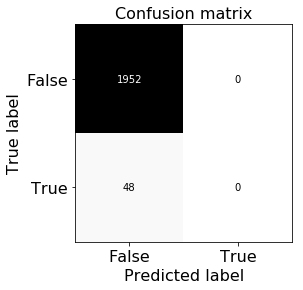

In [330]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, clf.predict(shap_values_rf_1_test[['19_SHAP']])), xlabel='Predicted label',
    ylabel='True label', xticklabels=['False', 'True'],
    yticklabels=['False', 'True'], cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [359]:
# X_train_shap_retrain = X_train_selected_sorted.iloc[:, 0:n_features]
# X_test_shap_retrain = X_test_selected_sorted.iloc[:, 0:n_features]
       #'c_SHAP'
xgb_train_shap_retrain = xgboost.DMatrix(shap_values_xgb_train[['a_SHAP', 'b_SHAP']], label=y_train_sampled)
xgb_test_shap_retrain = xgboost.DMatrix(shap_values_xgb_test[['a_SHAP', 'b_SHAP']], label=y_test)
    
selection_model = xgboost.train(params, xgb_train_shap_retrain, 100)
roc = roc_auc_score(y_test, selection_model.predict(xgb_test_shap_retrain))
print(roc)

0.739668715847
